Importing Libraries and functions

In [4]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

sys.path.append("./src")

from fft_pricer import fft_pricer
from fourier_integral import call_price_carr_madan
from error_time_module import fft_runs, plot_error_surface
from grid_module import generate_alpha_grid, generate_eta_grid, generate_n_grid

Setting up the mock data

In [5]:
S0 = 100.0
r = 0.05
sigma = 0.2
alpha = 1.25  

strikes_analysis = np.arange(60.0, 141.0, 1.0)

maturities = [0.1, 0.5, 1.0, 2.0]

results_df = pd.DataFrame(index=strikes_analysis)
results_df.index.name = "Strike"

Defining the function to calculate the call_price using bs in the closed form

In [6]:
def bs_call_price(S0: float, K: float, r: float, T: float, sigma: float) -> float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

Calcultating the various errors

In [7]:
for T in maturities:
    bs_prices = np.array([bs_call_price(S0, K, r, T, sigma) for K in strikes_analysis])
    
    K_fft, P_fft = fft_pricer(S0=S0, r=r, T=T, sigma=sigma, alpha=alpha)
    
    fft_prices_interp = np.interp(strikes_analysis, K_fft, P_fft)
    
    error = np.abs(fft_prices_interp - bs_prices)
    
    results_df[f'Error_T_{T}'] = error

Plotting

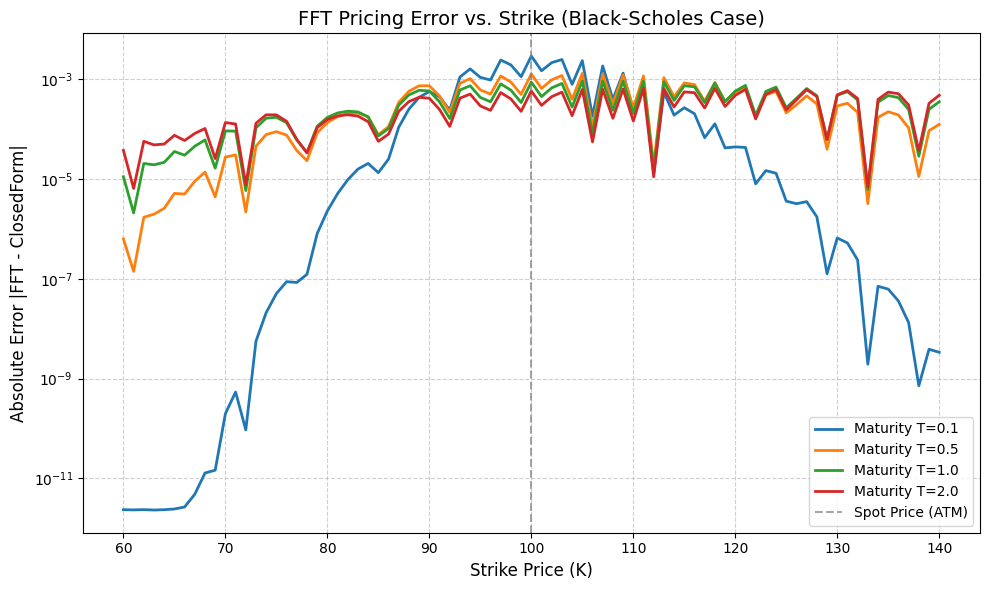


Prime righe del DataFrame degli errori:
         Error_T_0.1   Error_T_0.5  Error_T_1.0  Error_T_2.0
Strike                                                      
60.0    2.351896e-12  6.317005e-07     0.000011     0.000038
61.0    2.330580e-12  1.410572e-07     0.000002     0.000007
62.0    2.359002e-12  1.718801e-06     0.000021     0.000057
63.0    2.316369e-12  1.984921e-06     0.000019     0.000049
64.0    2.351896e-12  2.594198e-06     0.000022     0.000051


In [9]:
plt.figure(figsize=(10, 6))

for T in maturities:
    plt.plot(results_df.index, results_df[f'Error_T_{T}'], 
             label=f'Maturity T={T}', linewidth=2)

plt.title('FFT Pricing Error vs. Strike (Black-Scholes Case)', fontsize=14)
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Absolute Error |FFT - ClosedForm|', fontsize=12)

# Vertical line(ATM)
plt.axvline(x=S0, color='gray', linestyle='--', alpha=0.7, label='Spot Price (ATM)')

# log scale for y-axis
plt.yscale('log') 

plt.grid(True, which="both", linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.savefig('figures/error_vs_strikeprice.png')
plt.show()



print("\nPrime righe del DataFrame degli errori:")
print(results_df.head())

New setup

In [11]:
S0, r, T, sigma = 100.0, 0.05, 1.0, 0.2
alpha, eta = 1.25, 0.25

# Range di N da testare (Potenze di 2)
# Andiamo da 2^10 (1024) a 2^20 (circa 1 milione di punti) per vedere bene il trend
powers = np.arange(10, 21) 
N_values = 2**powers

# Liste per salvare i risultati
execution_times = []

print(f"Runtime Analysis: {N_values}...")

Runtime Analysis: [   1024    2048    4096    8192   16384   32768   65536  131072  262144
  524288 1048576]...


Measurement loop

In [12]:
for N in N_values:
    # Warm-up 
    if N == N_values[0]:
        _ = fft_pricer(S0, r, T, sigma, alpha, int(N), eta)

    # Start Timer
    start_time = time.perf_counter()
    
    _, _ = fft_pricer(S0, r, T, sigma, alpha, int(N), eta)
    
    # Stop Timer
    end_time = time.perf_counter()
    
    elapsed = end_time - start_time
    execution_times.append(elapsed)
    
    print(f"  N = {N:7d} (2^{int(np.log2(N)):2d}) -> Tempo: {elapsed:.6f} sec")



  N =    1024 (2^10) -> Tempo: 0.001223 sec
  N =    2048 (2^11) -> Tempo: 0.001871 sec
  N =    4096 (2^12) -> Tempo: 0.003263 sec
  N =    8192 (2^13) -> Tempo: 0.004937 sec
  N =   16384 (2^14) -> Tempo: 0.009735 sec
  N =   32768 (2^15) -> Tempo: 0.017394 sec
  N =   65536 (2^16) -> Tempo: 0.041177 sec
  N =  131072 (2^17) -> Tempo: 0.071992 sec
  N =  262144 (2^18) -> Tempo: 0.129497 sec
  N =  524288 (2^19) -> Tempo: 0.261211 sec
  N = 1048576 (2^20) -> Tempo: 0.482624 sec


Theoretical Curve Calculation O(N log N)

In [13]:
N_arr = np.array(N_values)
Times_arr = np.array(execution_times)

Theoretical_Complexity = N_arr * np.log2(N_arr)

# SCALING
k_factor = Times_arr[-1] / Theoretical_Complexity[-1]
Theoretical_Curve_Scaled = Theoretical_Complexity * k_factor


Plotting and report

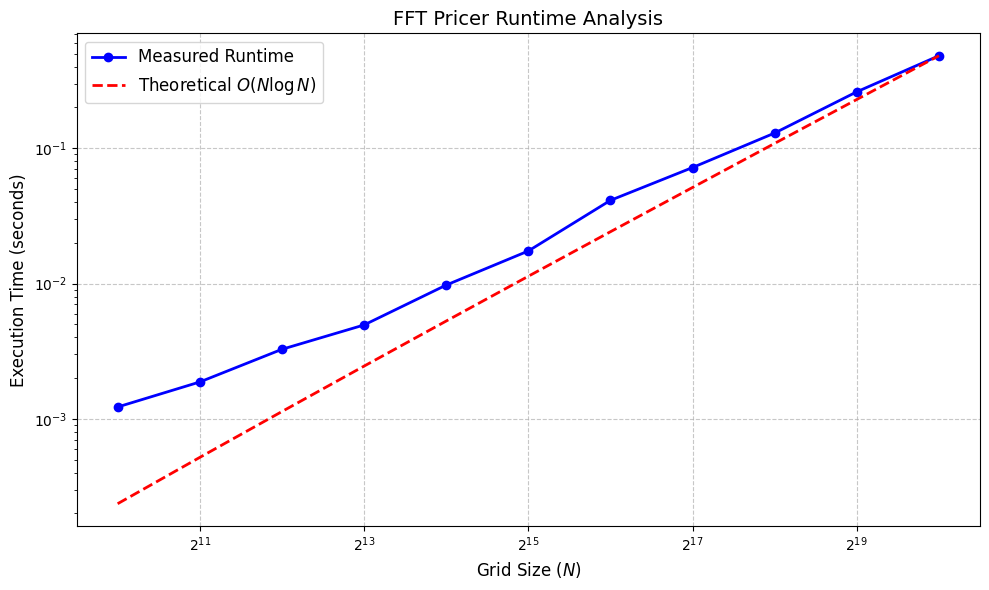

In [16]:
plt.figure(figsize=(10, 6))

# Plot dei Dati Misurati
plt.plot(N_arr, Times_arr, 'o-', color='blue', label='Measured Runtime', linewidth=2, markersize=6)

# Plot della Curva Teorica
plt.plot(N_arr, Theoretical_Curve_Scaled, '--', color='red', label=r'Theoretical $O(N \log N)$', linewidth=2)

plt.title('FFT Pricer Runtime Analysis', fontsize=14)
plt.xlabel('Grid Size ($N$)', fontsize=12)
plt.ylabel('Execution Time (seconds)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Miglioramento asse X: Mostra le potenze di 2
plt.xscale('log', base=2) 
plt.yscale('log') # Log-Log plot è ottimo per verificare le leggi di potenza

plt.tight_layout()

plt.savefig('figures/theoretical_curve_fft.png')
plt.show()

Setting up the data

In [17]:
S0 = 100.0
r = 0.01
T = 1.0
K = 100
sigma = 0.2

num_steps = 100
alpha_grid = generate_alpha_grid(alpha_lower_bound=0.5, alpha_upper_bound=2.5, num_steps=num_steps)
eta_grid = generate_eta_grid(min_eta=0.1, max_eta=0.5, num_steps=num_steps)
n_grid = generate_n_grid(min_power=1, max_power=15)

Generating alpha grid from 0.5 to 2.5000.
Generating eta grid from 0.1 to 0.5.
Generating N grid (powers of 2): [    2     4     8    16    32    64   128   256   512  1024  2048  4096
  8192 16384 32768]


Running the FFT pricer function

In [18]:
bs_price = bs_call_price(S0, K, r, T, sigma)
exp_df = fft_runs(alpha_grid, eta_grid, n_grid, bs_price, fft_pricer, S0, T, sigma, r, K)

Plotting

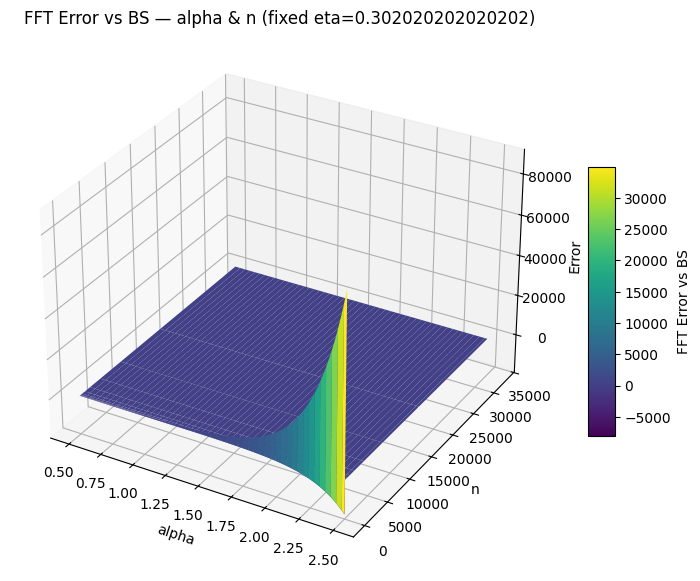

In [23]:
plot_error_surface(exp_df, 'alpha', 'n', 'eta', eta_grid[50], 'surface3d')

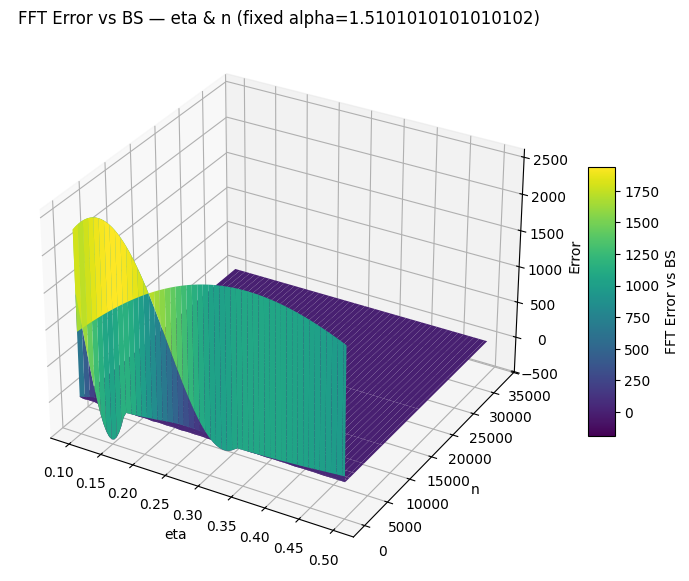

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_error_surface(exp_df, 'eta', 'n', 'alpha', alpha_grid[50], 'surface3d')